# Heavy quarks probing Glasma flux tubes

## Default simulation parameters for the Glasma and the Wong solvers.

In [6]:
import numpy as np

# Define hbar * c in units of GeV * fm
hbarc = 0.197326 

# General parameters
su_group = 'su3'        # Gauge group

# Simulation box parameters
L = 10      # Length of simulation box [fm]
N = 512     # Number of lattice sites
tau_sim = 0.4     # Simulation time [fm/c]
DTS = 8     # Time step

# MV model parameters
Qs = 2              # Saturation momentum [GeV]	
ns = 1     # Number of color sheets
g = 2.0           # Running coupling constant	
mu = 0.5           # MV model parameter	
ir = 0.2        # Infrared regulator [GeV]
uv = 10.0           # Ultraviolet regulator [GeV]

# Heavy quark related parameters, chosen here for a charm quark
quark = 'charm'     # Quark type
mass = 1.27      # Heavy quark mass [GeV]
tau_form = 1/(2*mass)*hbarc     # Formation time [fm/c]
pT = 0    # Initial transverse momentum [GeV]
ntp = 100   # Number of test particles

# Store relevant parameters in a dictionary
p = {
    'QUARK': quark,
    'MASS': mass,           
    'TFORM': tau_form,       
    'PT': pT, 
    }

## Set environment variables and import all relevant modules.

In [7]:
import os
os.environ["MY_NUMBA_TARGET"] = "cuda"
os.environ["PRECISION"] = "double"
os.environ["GAUGE_GROUP"] = su_group

# Import relevant modules
import sys
sys.path.append('..')

# Glasma modules
import curraun.core as core
import curraun.mv as mv
import curraun.initial as initial
initial.DEBUG = False
# Wong modules
from curraun import wong
wong.DEBUG = False
wong.REPRESENTATION = 'fundamental'
wong.BOUNDARY = 'periodic'
from curraun.wong import init_charge
# Energy density
from curraun.energy import Energy

import curraun.su as su
from curraun.numba_target import use_cuda
if use_cuda:
    from numba import cuda

## Glasma energy density

In [8]:
from tqdm import tqdm
import pickle

# Derived parameters
a = L / N
E0 = N / L * hbarc
DT = 1.0 / DTS
formt = int(p['TFORM'] / a * DTS)
maxt = int(tau_sim / a * DTS)

# Initialize Glasma fields
mv.set_seed(314)
s = core.Simulation(N, DT, g)
va = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
vb = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
initial.init(s, va, vb)

# Initialize energy computation
energy = Energy(s)
ed = []
taus = [1, formt, maxt]

with tqdm(total=maxt) as pbar:
    for t in range(1, maxt+1):
        # Evolve Glasma fields
        core.evolve_leapfrog(s)

        if t in taus:
            # Energy density calculation
            energy.compute()
            # units [Gev / fm^3]
            units = E0 ** 4 / hbarc ** 3
            el, bl, et, bt = energy.EL.reshape(N, N), energy.BL.reshape(N, N), energy.ET.reshape(N, N), energy.BT.reshape(N, N)
            e = (el+et+bl+bt)/t/g**2
            ed.append(e*units)

        pbar.update(1)

output = {}
output['ed'], output['N'], output['L'] = ed, N, L
filename = 'energy_density_background.pickle'
with open(filename, 'wb') as handle:
    pickle.dump(output, handle)

100%|██████████| 163/163 [00:26<00:00,  6.07it/s]


## Simulation routine for evolving the Glasma & solving Wong's equations
Stores positions and momenta for the particles and the energy density of a single Glasma event

In [9]:
from tqdm import tqdm
import pickle

# Simulation routine
def simulate(p): 
    # Derived parameters
    a = L / N
    E0 = N / L * hbarc
    DT = 1.0 / DTS
    formt = int(p['TFORM'] / a * DTS)
    maxt = int(tau_sim / a * DTS)

    # Initialize Glasma fields
    mv.set_seed(314)
    s = core.Simulation(N, DT, g)
    va = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    vb = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    initial.init(s, va, vb)

    # Initialize the Wong solver
    wong_solver = wong.WongSolver(s, ntp)
    pT = p['PT'] / E0
    x0s, p0s, q0s = np.zeros((ntp, 3)), np.zeros((ntp, 4)), np.zeros((ntp, su.ALGEBRA_ELEMENTS))
    mass = p['MASS'] / E0 
    m = mass * np.ones(ntp)
    angles = 2*np.pi*np.random.rand(ntp)

    for i in range(ntp):
        # Positions
        xT = np.random.rand(2) * s.n
        x0 = [xT[0], xT[1], 0.0]
        # Momenta
        p0 = [0.0, pT * np.cos(angles[i]), pT * np.sin(angles[i]), 0.0]
        # Charges
        q0 = init_charge()

        x0s[i, :], p0s[i, :], q0s[i, :] = x0, p0, q0

    wong_solver.initialize(x0s, p0s, q0s, m)
    xTs = np.zeros((maxt-formt, ntp, 2))
    pTs = np.zeros((maxt-formt, ntp, 2))

    with tqdm(total=maxt) as pbar:
        for t in range(maxt):
            # Evolve Glasma fields
            core.evolve_leapfrog(s)

            # Solve Wong's equations
            if t>=formt:  
                wong_solver.evolve()
                x = wong_solver.x0.copy()
                p = wong_solver.p.copy()
                for ip in range(ntp):
                    xTs[t-formt, ip, :] = [x[ip, 0], x[ip, 1]]
                    pTs[t-formt, ip, :] = [p[ip, 1] * E0, p[ip, 2] * E0]

            pbar.update(1)

    return xTs, pTs

## Run for various transverse momenta and quarks

In [10]:
# quarks = ['charm', 'beauty']
# quark_masses = [1.27, 4.18]
# pTs = [0.5, 5.0, 10.0]

quarks = ['charm']
quark_masses = [1.27]
pTs = [0]

xT_sim, pT_sim, tau = {}, {}, {}
for iq in range(len(quarks)):
    p['QUARK'], p['MASS'] = quarks[iq], quark_masses[iq]
    p['TFORM'] = 1/(2*p['MASS'])*hbarc 
    print(p['QUARK'].capitalize() + " quark")

    for pT in pTs:
        print('Transverse momentum', pT, 'GeV')
        p['PT'] = pT
        tag = quarks[iq] + '_pT_' + str(pT)
        
        formt, maxt = int(p['TFORM'] / L * N * DTS), int(tau_sim / L * N * DTS)
        tau_s = np.linspace(p['TFORM'], tau_sim, maxt-formt)

        xT_sim[tag], pT_sim[tag] = simulate(p)
        tau[tag] = tau_s

output = {}
output['quarks'], output['pTs'], output['masses'] = quarks, pTs, quark_masses
output['xT'], output['pT'], output['tau'] = xT_sim, pT_sim, tau
filename = 'trajectories.pickle'
with open(filename, 'wb') as handle:
    pickle.dump(output, handle)

Charm quark
Transverse momentum 0 GeV


100%|██████████| 163/163 [00:46<00:00,  3.51it/s]


## Read data from file using Julia

In [1]:
using Pickle

data_particles = Pickle.npyload("trajectories.pickle")
quarks, pTs = data_particles["quarks"], data_particles["pTs"]
xT, p, tau = data_particles["xT"], data_particles["pT"], data_particles["tau"]

data_fields = Pickle.npyload("energy_density_background.pickle")
ed, N, L = data_fields["ed"], data_fields["N"], data_fields["L"]

(Any[[70.26554264804555 39.577660687069795 … 81.4475988721321 91.81702534976418; 137.6063653174239 74.33269024088882 … 139.77942614194905 164.68815381779154; … ; 51.69169228740047 56.62565681253966 … 27.540938431336045 35.36724239408165; 38.68150671294765 31.966399151841646 … 39.44312818415655 42.962215895499355], [22.430061586956235 21.2055018129362 … 23.223145146305956 23.078946704045666; 24.912698225428084 25.149047011350934 … 26.562512368508905 25.208942128887585; … ; 16.231819984675333 14.689761033025727 … 16.858535102519777 17.064367117112347; 19.58985568885887 17.929803491857726 … 19.684708322516162 20.186574855878586], [7.167548556996602 6.484748299533035 … 7.343960714870011 7.575845610703547; 6.909050475644687 6.244391789135312 … 6.869560097550432 7.243110772541901; … ; 6.558507855202381 6.26898730528201 … 6.953641176396913 6.940736412623106; 6.9610727783442226 6.502594214123348 … 7.266555914236629 7.320160493499052]], 512, 10)

## Plot using Makie from Julia

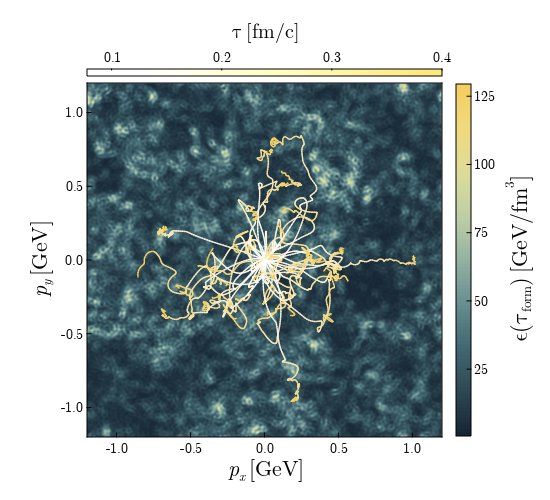

CairoScreen{Cairo.CairoSurfaceBase{UInt32}} with surface:
Cairo.CairoSurfaceBase{UInt32}(Ptr{Nothing} @0x000000000f1c3a40, 2750.0, 2500.0)


In [18]:
using CairoMakie
using Interpolations
using ColorSchemes

starrynight = cgrad(:starrynight, 11, categorical = true)

fig = Figure(resolution = (550, 500), font = "CMU Serif")
ax = Axis(fig[2, 1], aspect=1, 
        xlabel=L"p_x\,\mathrm{[GeV]}", ylabel=L"p_y\,\mathrm{[GeV]}",
        xlabelsize = 22, ylabelsize= 22, xtickalign = 1, xticksize=5, ytickalign=1, yticksize=5, xticklabelsize = 14, yticklabelsize = 14, xlabelpadding = -5)

step = 1/8
a = L/N
xlow, xhigh, ylow, yhigh = -1.2, 1.2, -1.2, 1.2
x, y = xlow:(1/N):xhigh, ylow:(1/N):yhigh

interp = interpolate(ed[2], BSpline(Quadratic(Reflect(OnCell()))))
ed_interp = interp(1:step:N, 1:step:N)


hmap = heatmap!(ax, x, y, ed_interp, colormap = (:starrynight, 1))
cbar = Colorbar(fig, hmap, label = L"\epsilon(\tau_\mathrm{form})\,\mathrm{[GeV/fm^3]}", labelsize = 22, width = 15, flipaxis = true,
        ticksize=5, tickalign = 1, ticklabelsize = 14, height = Relative(3.97/4))
fig[2, 2] = cbar
colgap!(fig.layout, 7)
   
tag = quarks[1]*"_pT_"*string(pTs[1])
ntp = size(xT[tag])[2]
for tp in 1:40
    currp = pTs[1]
    line = lines!(ax, p[tag][:,tp,1], p[tag][:,tp,2], linewidth = 1.4, color = tau[tag], colormap = cgrad([:white, starrynight[11]], alpha=0.9))
    if tp==1
        cbarline = Colorbar(fig, line, label = L"\tau \,\mathrm{[fm/c]}", labelsize=20, vertical = false, flipaxis = true, 
            ticksize=2, tickalign = 1, ticklabelsize = 14, width = Relative(3.84/4), height = 7)
        fig[1, 1] = cbarline
    end
    rowgap!(fig.layout, 7)
    
end
xlims!(ax, xlow, xhigh)
ylims!(ax, ylow, yhigh)

display(fig)
# save("hqs_trajectories.png", fig, px_per_unit = 5.0) 

In [ ]:
using CairoMakie
using Interpolations
using ColorSchemes

starrynight = cgrad(:starrynight, 11, categorical = true)

fig = Figure(resolution = (845, 500), font = "CMU Serif")
ax = Axis(fig[1, 1], aspect=1)

step = 1/16
a = L/N
xlow, xhigh, ylow, yhigh = -1.2, 1.2, -1.2, 1.2
x, y = xlow:(1/N):xhigh, ylow:(1/N):yhigh

interp = interpolate(ed[3], BSpline(Quadratic(Reflect(OnCell()))))
ed_interp = interp(1:step:N, 1:step:N)


hmap = heatmap!(ax, x, y, ed_interp, colormap = (:starrynight, 1))

tag = quarks[1]*"_pT_"*string(pTs[1])
ntp = size(xT[tag])[2]
for tp in 1:60
    currp = pTs[1]
    line = lines!(ax, p[tag][:,tp,1], p[tag][:,tp,2], linewidth = 1.8, color = tau[tag], colormap = cgrad([:white, starrynight[11]], alpha=1))   
end
xlims!(ax, xlow, xhigh)
ylims!(ax, ylow, yhigh)
hidexdecorations!(ax, grid = false)
hideydecorations!(ax, grid = false)
ax.aspect = AxisAspect(1.69)

display(fig)
# save("hqs_glasma_background.png", fig, px_per_unit = 10.0) 